# FPSci Latency Study - Visualizations

This notebook creates publication-quality visualizations of the experimental
results.

## Visualizations

1. Performance vs Latency (by game)
2. QoE vs Latency
3. Box plots by latency condition
4. Individual participant trajectories
5. Correlation heatmaps
6. Combined performance-QoE plots


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Set style for publication-quality figures
sns.set_style('whitegrid')
sns.set_context('paper', font_scale=1.5)
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial', 'DejaVu Sans']

# Color palette
COLORS = sns.color_palette('husl', 5)
LATENCY_COLORS = sns.color_palette('RdYlGn_r', 4)

## 1. Load Data


In [3]:
DATA_DIR = Path('../analysis/processed_data')
OUTPUT_DIR = Path('../analysis/figures')
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

# Load combined data
df = pd.read_csv(DATA_DIR / 'combined_data.csv')

print(f"Loaded {len(df)} observations")
print(f"Participants: {len(df['participant_id'].unique())}")
print(f"Games: {df['game_display'].unique()}")
print(f"Latency conditions: {sorted(df['latency_ms'].unique())}")

Loaded 300 observations
Participants: 17
Games: <StringArray>
['Dave the Diver', 'Half-Life 2', 'Fitts Law', 'Feeding Frenzy',
 'Rocket League']
Length: 5, dtype: str
Latency conditions: [np.float64(0.0), np.float64(75.0), np.float64(150.0), np.float64(225.0)]


## 2. Performance vs Latency (Per Game)


Saved: ../analysis/figures/performance_vs_latency_by_game.png


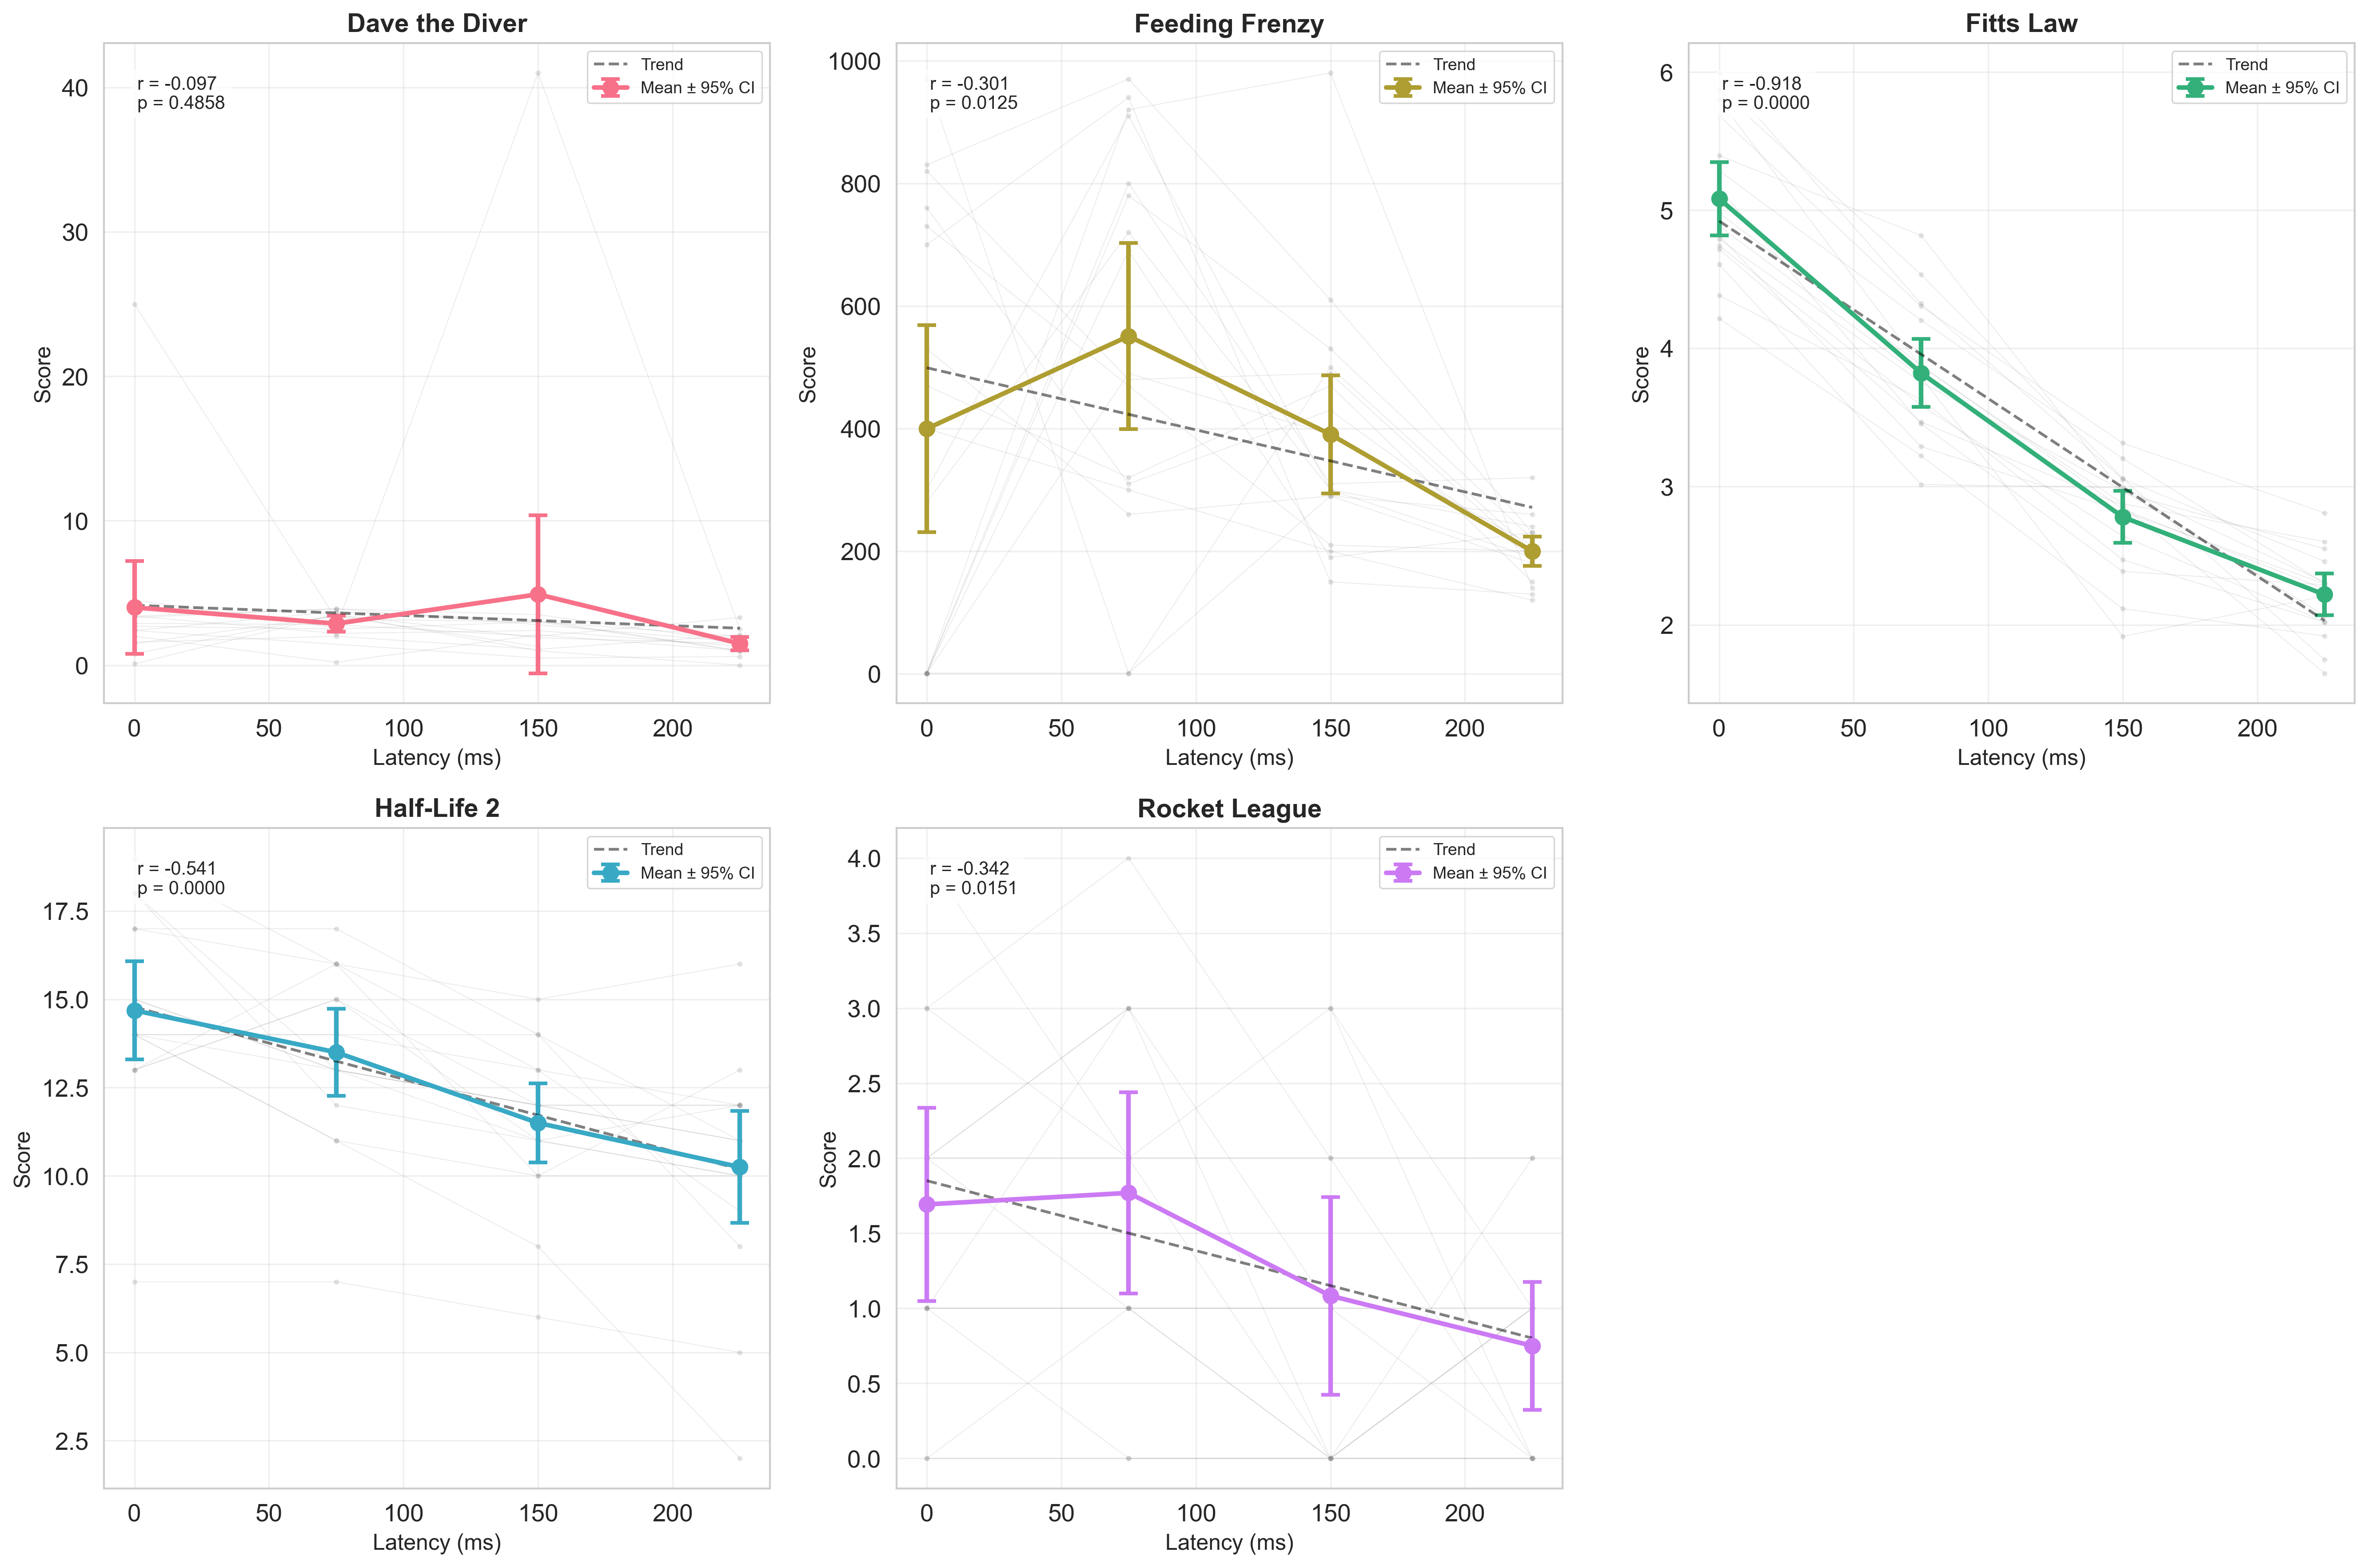

In [ ]:
# Create figure with subplots for each game
games = sorted(df['game_display'].unique())
n_games = len(games)

fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

for idx, game in enumerate(games):
    ax = axes[idx]
    game_df = df[df['game_display'] == game].copy()

    # Plot individual participant trajectories (faint lines)
    for participant_id in game_df['participant_id'].unique():
        participant_data = game_df[game_df['participant_id'] == participant_id].sort_values('latency_ms')
        ax.plot(participant_data['latency_ms'], participant_data['score'],
                alpha=0.15, color='gray', linewidth=0.5, marker='o', markersize=2)

    # Calculate means and confidence intervals
    summary = game_df.groupby('latency_ms')['score'].agg(['mean', 'sem', 'count']).reset_index()
    summary['ci'] = summary['sem'] * 1.96  # 95% CI

    # Plot mean line with confidence interval
    ax.errorbar(summary['latency_ms'], summary['mean'], yerr=summary['ci'],
                marker='o', markersize=8, linewidth=2.5, capsize=5, capthick=2,
                color=COLORS[idx % len(COLORS)], label='Mean ± 95% CI')

    # Add regression line
    z = np.polyfit(game_df['latency_ms'], game_df['score'], 1)
    p = np.poly1d(z)
    latency_range = np.linspace(game_df['latency_ms'].min(), game_df['latency_ms'].max(), 100)
    ax.plot(latency_range, p(latency_range), '--', color='black', alpha=0.5, linewidth=1.5, label='Trend')

    # Calculate correlation for annotation
    r, p_val = stats.pearsonr(game_df['latency_ms'], game_df['score'])

    ax.set_title(game, fontsize=14, fontweight='bold')
    ax.set_xlabel('Latency (ms)', fontsize=12)
    ax.set_ylabel('Score', fontsize=12)
    ax.grid(True, alpha=0.3)
    ax.legend(loc='best', fontsize=9)

    # Add correlation annotation
    ax.text(0.05, 0.95, f'r = {r:.3f}\np = {p_val:.4f}',
            transform=ax.transAxes, fontsize=10, verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# Remove extra subplot if odd number of games
if n_games < len(axes):
    fig.delaxes(axes[-1])

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'performance_vs_latency_by_game.png', bbox_inches='tight')
plt.savefig(OUTPUT_DIR / 'performance_vs_latency_by_game.pdf', bbox_inches='tight')
print(f"Saved: {OUTPUT_DIR / 'performance_vs_latency_by_game.png'}")
plt.show()

## 3. QoE vs Latency


Saved: ../analysis/figures/qoe_vs_latency.png


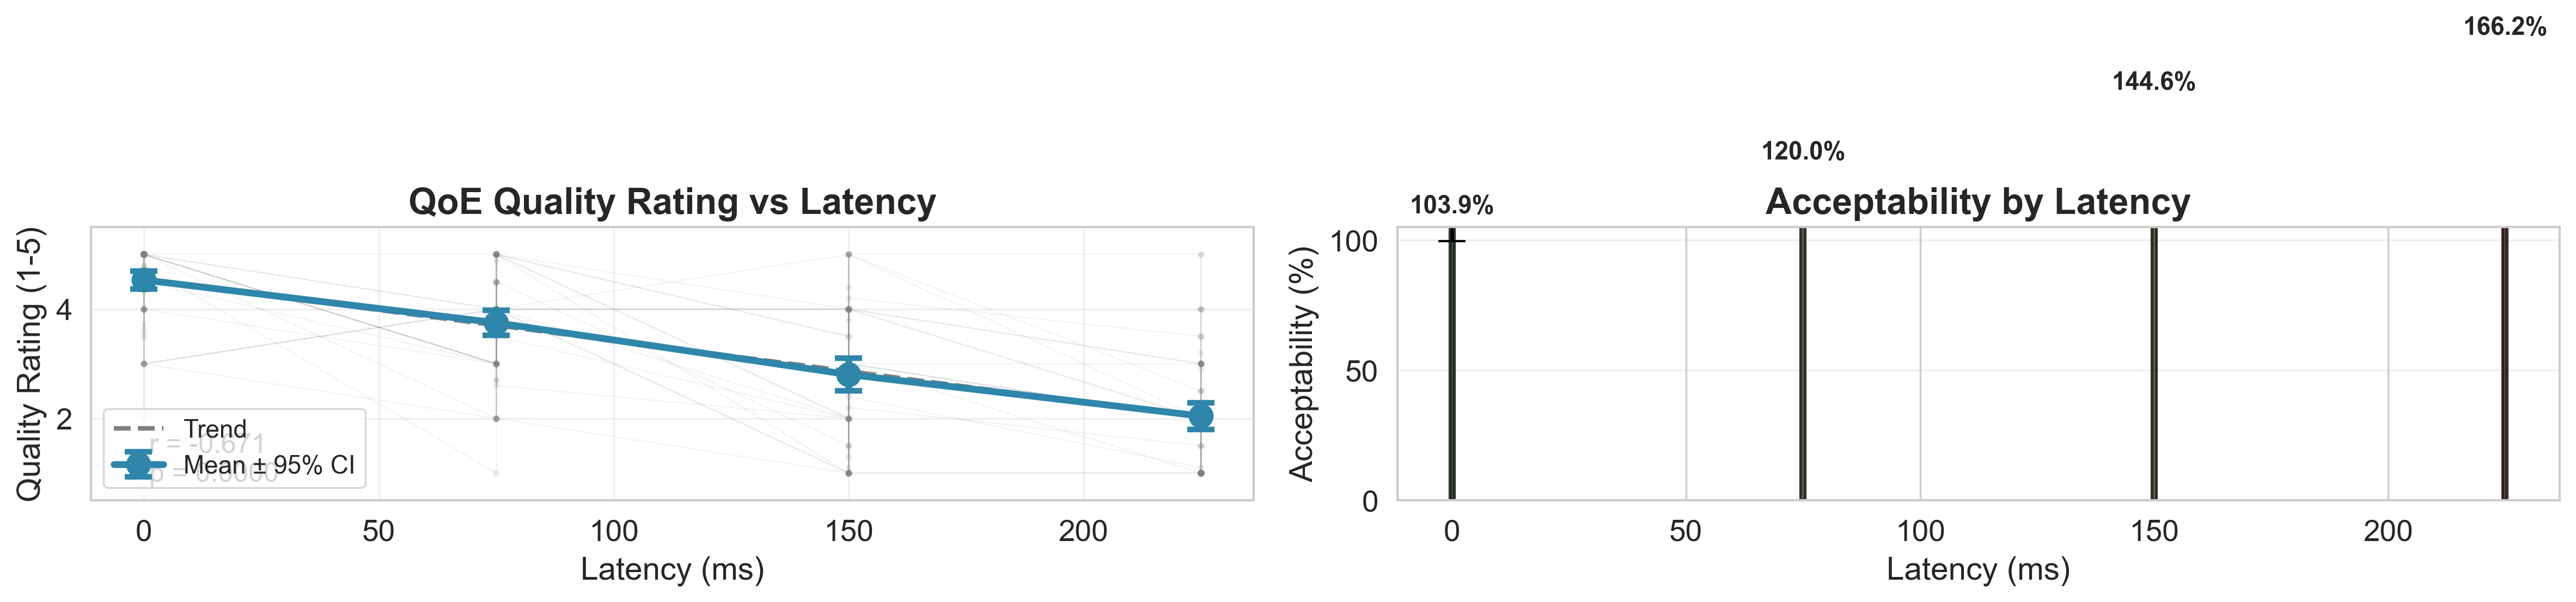

In [ ]:
qoe_valid = df.dropna(subset=['quality_rating', 'acceptable'])

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Quality Rating
# Individual trajectories
for participant_id in qoe_valid['participant_id'].unique():
    participant_data = qoe_valid[qoe_valid['participant_id'] == participant_id].sort_values('latency_ms')
    ax1.plot(participant_data['latency_ms'], participant_data['quality_rating'],
            alpha=0.1, color='gray', linewidth=0.5, marker='o', markersize=2)

# Mean line
qoe_summary = qoe_valid.groupby('latency_ms')['quality_rating'].agg(['mean', 'sem']).reset_index()
qoe_summary['ci'] = qoe_summary['sem'] * 1.96

ax1.errorbar(qoe_summary['latency_ms'], qoe_summary['mean'], yerr=qoe_summary['ci'],
            marker='o', markersize=10, linewidth=3, capsize=6, capthick=2.5,
            color='#2E86AB', label='Mean ± 95% CI')

# Regression line
z = np.polyfit(qoe_valid['latency_ms'], qoe_valid['quality_rating'], 1)
p = np.poly1d(z)
latency_range = np.linspace(qoe_valid['latency_ms'].min(), qoe_valid['latency_ms'].max(), 100)
ax1.plot(latency_range, p(latency_range), '--', color='black', alpha=0.5, linewidth=2, label='Trend')

r, p_val = stats.pearsonr(qoe_valid['latency_ms'], qoe_valid['quality_rating'])
ax1.text(0.05, 0.05, f'r = {r:.3f}\np = {p_val:.4f}',
        transform=ax1.transAxes, fontsize=12, verticalalignment='bottom',
        bbox=dict(boxstyle='round', facecolor='white', alpha=0.9))

ax1.set_xlabel('Latency (ms)', fontsize=14)
ax1.set_ylabel('Quality Rating (1-5)', fontsize=14)
ax1.set_title('QoE Quality Rating vs Latency', fontsize=16, fontweight='bold')
ax1.set_ylim(0.5, 5.5)
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3)

# Plot 2: Acceptability
accept_summary = qoe_valid.groupby('latency_ms')['acceptable'].agg(['mean', 'sem', 'count']).reset_index()
accept_summary['ci'] = accept_summary['sem'] * 1.96
accept_summary['mean_pct'] = accept_summary['mean'] * 100
accept_summary['ci_pct'] = accept_summary['ci'] * 100

ax2.bar(accept_summary['latency_ms'], accept_summary['mean_pct'],
       yerr=accept_summary['ci_pct'], capsize=6,
       color=LATENCY_COLORS, alpha=0.8, edgecolor='black', linewidth=1.5)

ax2.set_xlabel('Latency (ms)', fontsize=14)
ax2.set_ylabel('Acceptability (%)', fontsize=14)
ax2.set_title('Acceptability by Latency', fontsize=16, fontweight='bold')
ax2.set_ylim(0, 105)
ax2.grid(True, alpha=0.3, axis='y')

# Add percentage labels on bars
for i, row in accept_summary.iterrows():
    ax2.text(row['latency_ms'], row['mean_pct'] + row['ci_pct'] + 2,
            f"{row['mean_pct']:.1f}%", ha='center', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'qoe_vs_latency.png', bbox_inches='tight')
plt.savefig(OUTPUT_DIR / 'qoe_vs_latency.pdf', bbox_inches='tight')
print(f"Saved: {OUTPUT_DIR / 'qoe_vs_latency.png'}")
plt.show()

## 4. Box Plots by Latency


Saved: ../analysis/figures/boxplots_by_latency.png


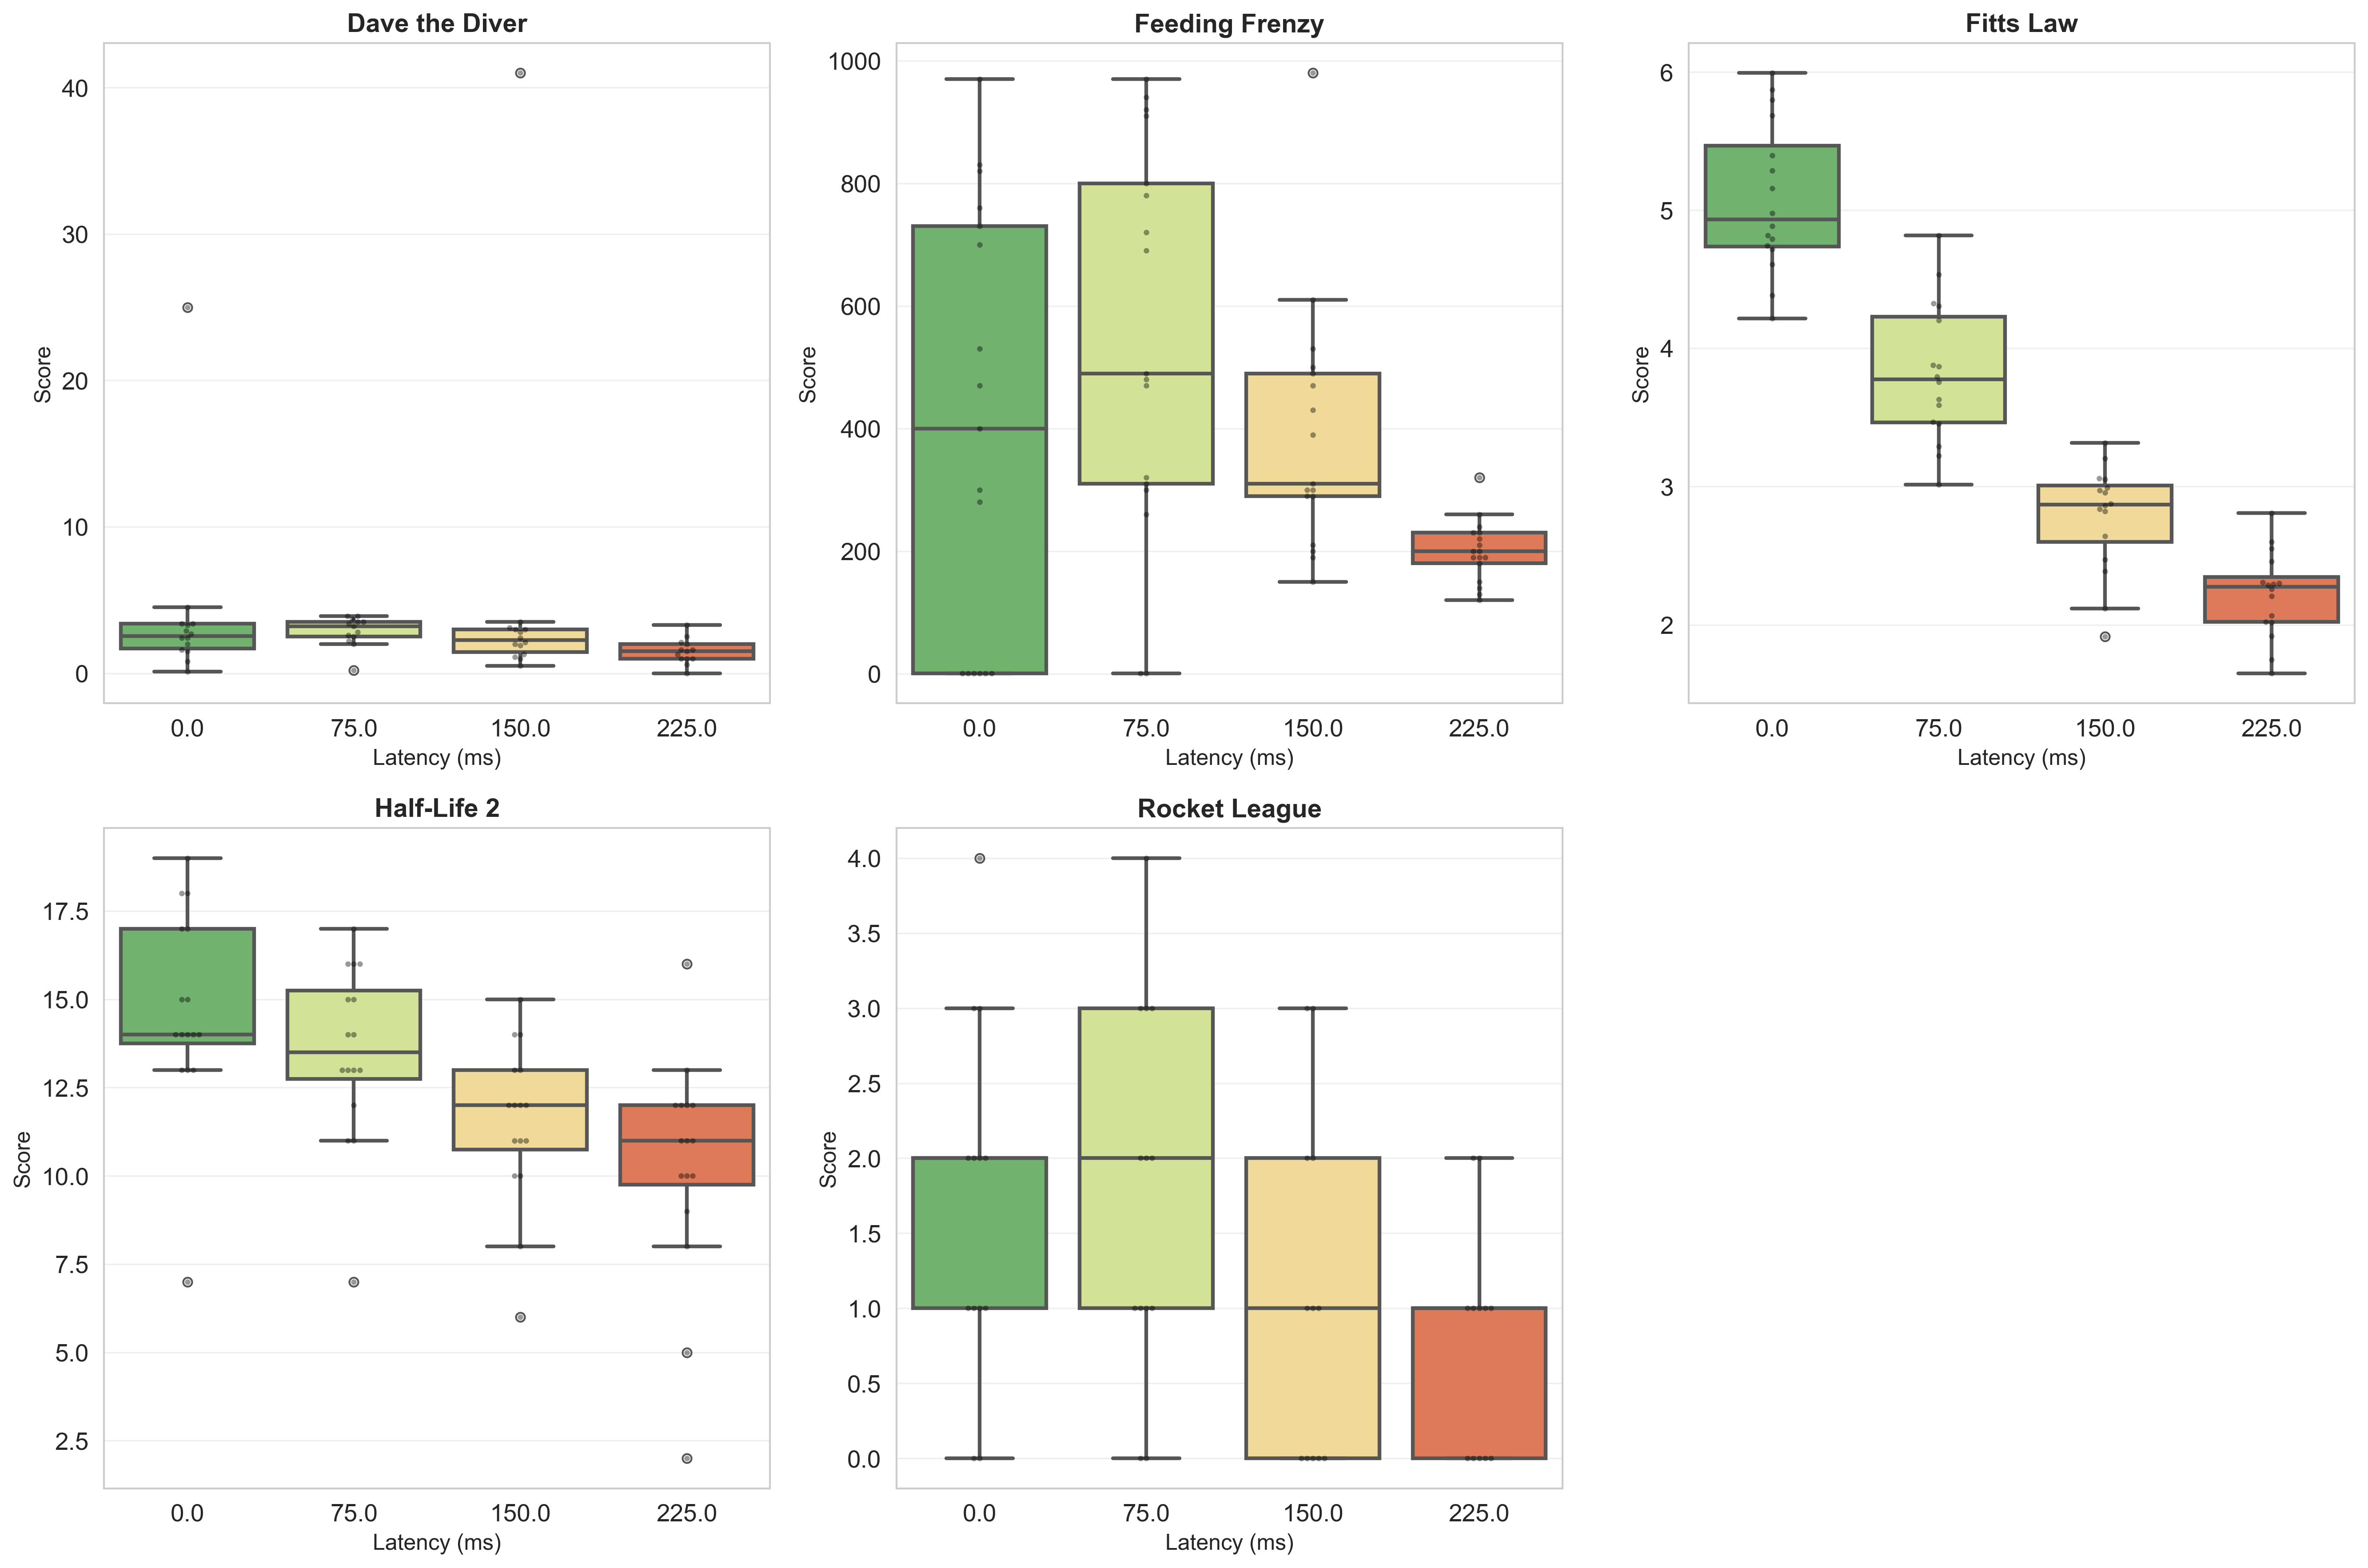

In [ ]:
# Box plots for performance (z-scored) by latency
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

for idx, game in enumerate(games):
    ax = axes[idx]
    game_df = df[df['game_display'] == game]

    sns.boxplot(data=game_df, x='latency_ms', y='score', ax=ax,
               palette=LATENCY_COLORS, linewidth=2)

    # Add swarm plot for individual points
    sns.swarmplot(data=game_df, x='latency_ms', y='score', ax=ax,
                 color='black', alpha=0.4, size=3)

    ax.set_title(game, fontsize=14, fontweight='bold')
    ax.set_xlabel('Latency (ms)', fontsize=12)
    ax.set_ylabel('Score', fontsize=12)
    ax.grid(True, alpha=0.3, axis='y')

# Remove extra subplot
if n_games < len(axes):
    fig.delaxes(axes[-1])

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'boxplots_by_latency.png', bbox_inches='tight')
plt.savefig(OUTPUT_DIR / 'boxplots_by_latency.pdf', bbox_inches='tight')
print(f"Saved: {OUTPUT_DIR / 'boxplots_by_latency.png'}")
plt.show()

## 5. Individual Participant Trajectories


Saved: ../analysis/figures/individual_trajectories.png


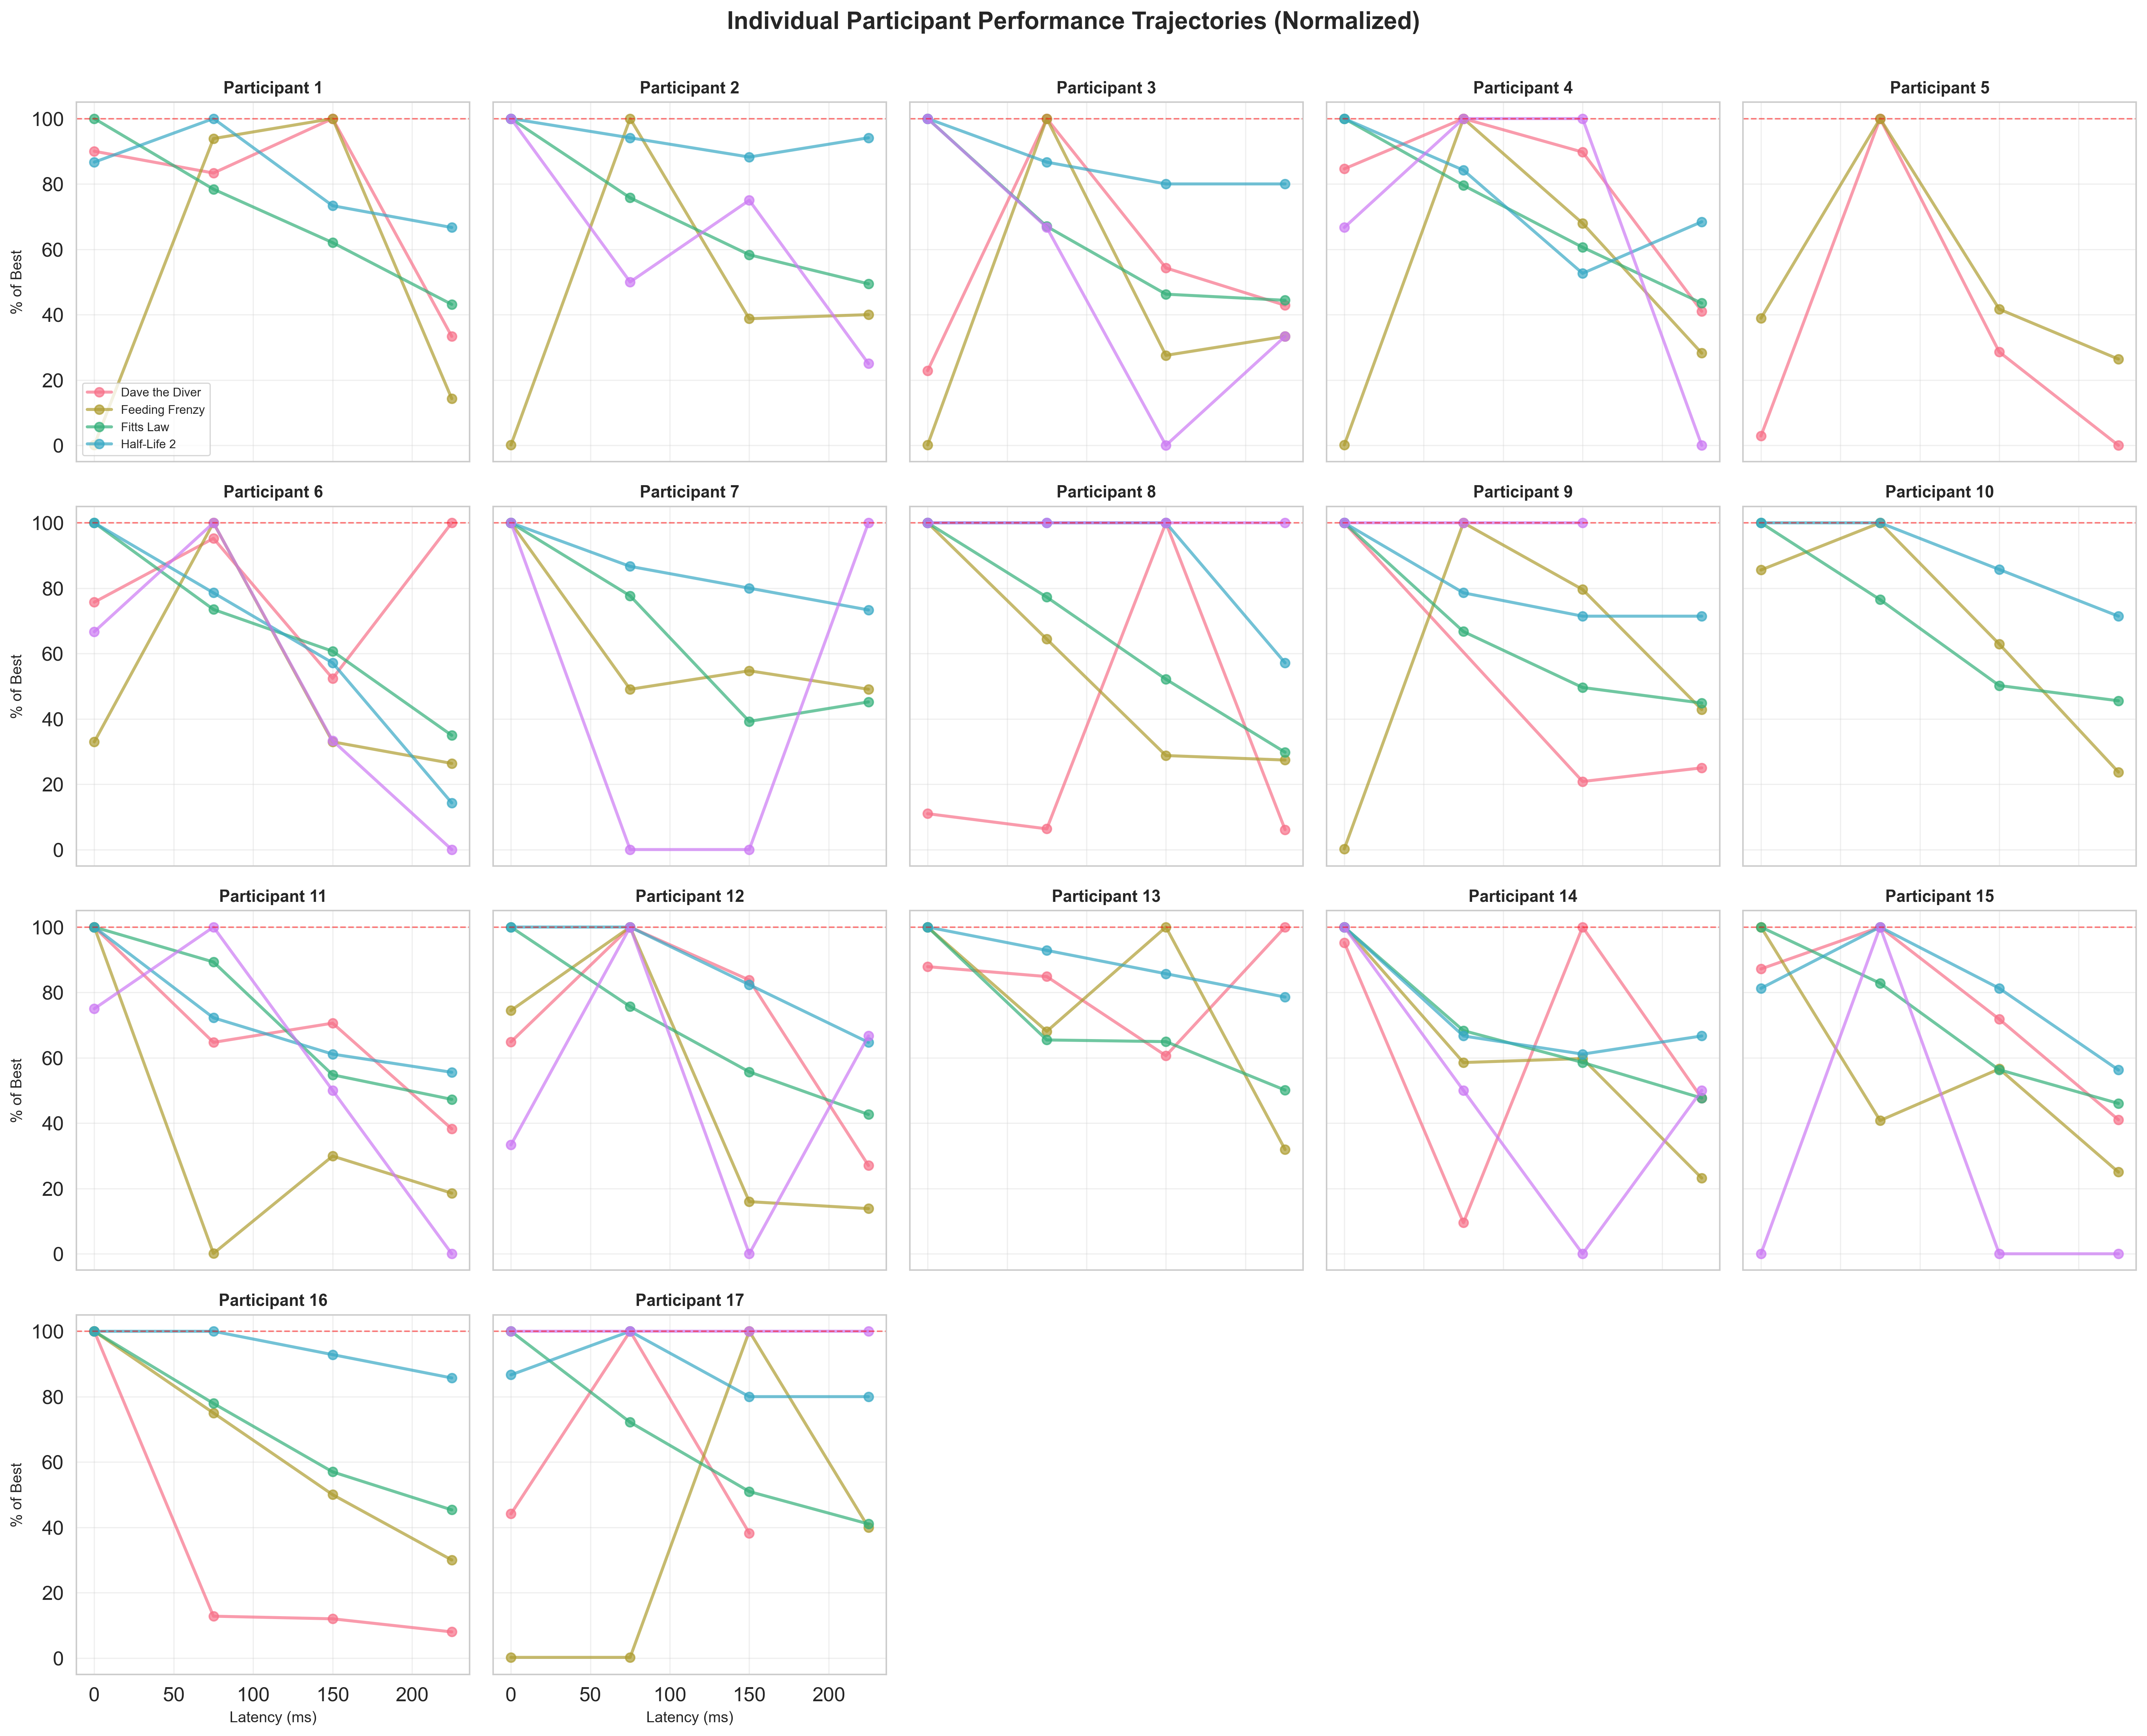

In [ ]:
# Show normalized scores (percent of baseline) for each participant
participants = sorted(df['participant_id'].unique())
n_participants = len(participants)

# Calculate optimal grid
ncols = 5
nrows = int(np.ceil(n_participants / ncols))

fig, axes = plt.subplots(nrows, ncols, figsize=(20, 4*nrows), sharex=True, sharey=True)
axes = axes.flatten()

for idx, participant_id in enumerate(participants):
    ax = axes[idx]
    participant_df = df[df['participant_id'] == participant_id]

    for game_idx, game in enumerate(games):
        game_data = participant_df[participant_df['game_display'] == game].sort_values('latency_ms')
        if len(game_data) > 0:
            ax.plot(game_data['latency_ms'], game_data['score_pct_of_baseline'],
                   marker='o', linewidth=2, markersize=6,
                   color=COLORS[game_idx % len(COLORS)], label=game, alpha=0.7)

    ax.set_title(f'Participant {participant_id}', fontsize=11, fontweight='bold')
    ax.grid(True, alpha=0.3)
    ax.axhline(y=100, color='red', linestyle='--', alpha=0.5, linewidth=1)

    if idx >= (nrows-1) * ncols:
        ax.set_xlabel('Latency (ms)', fontsize=10)
    if idx % ncols == 0:
        ax.set_ylabel('% of Best', fontsize=10)

    if idx == 0:
        ax.legend(fontsize=8, loc='lower left')

# Remove extra subplots
for idx in range(n_participants, len(axes)):
    fig.delaxes(axes[idx])

plt.suptitle('Individual Participant Performance Trajectories (Normalized)',
            fontsize=16, fontweight='bold', y=1.00)
plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'individual_trajectories.png', bbox_inches='tight')
plt.savefig(OUTPUT_DIR / 'individual_trajectories.pdf', bbox_inches='tight')
print(f"Saved: {OUTPUT_DIR / 'individual_trajectories.png'}")
plt.show()

## 6. Correlation Heatmap


Saved: ../analysis/figures/correlation_heatmap.png


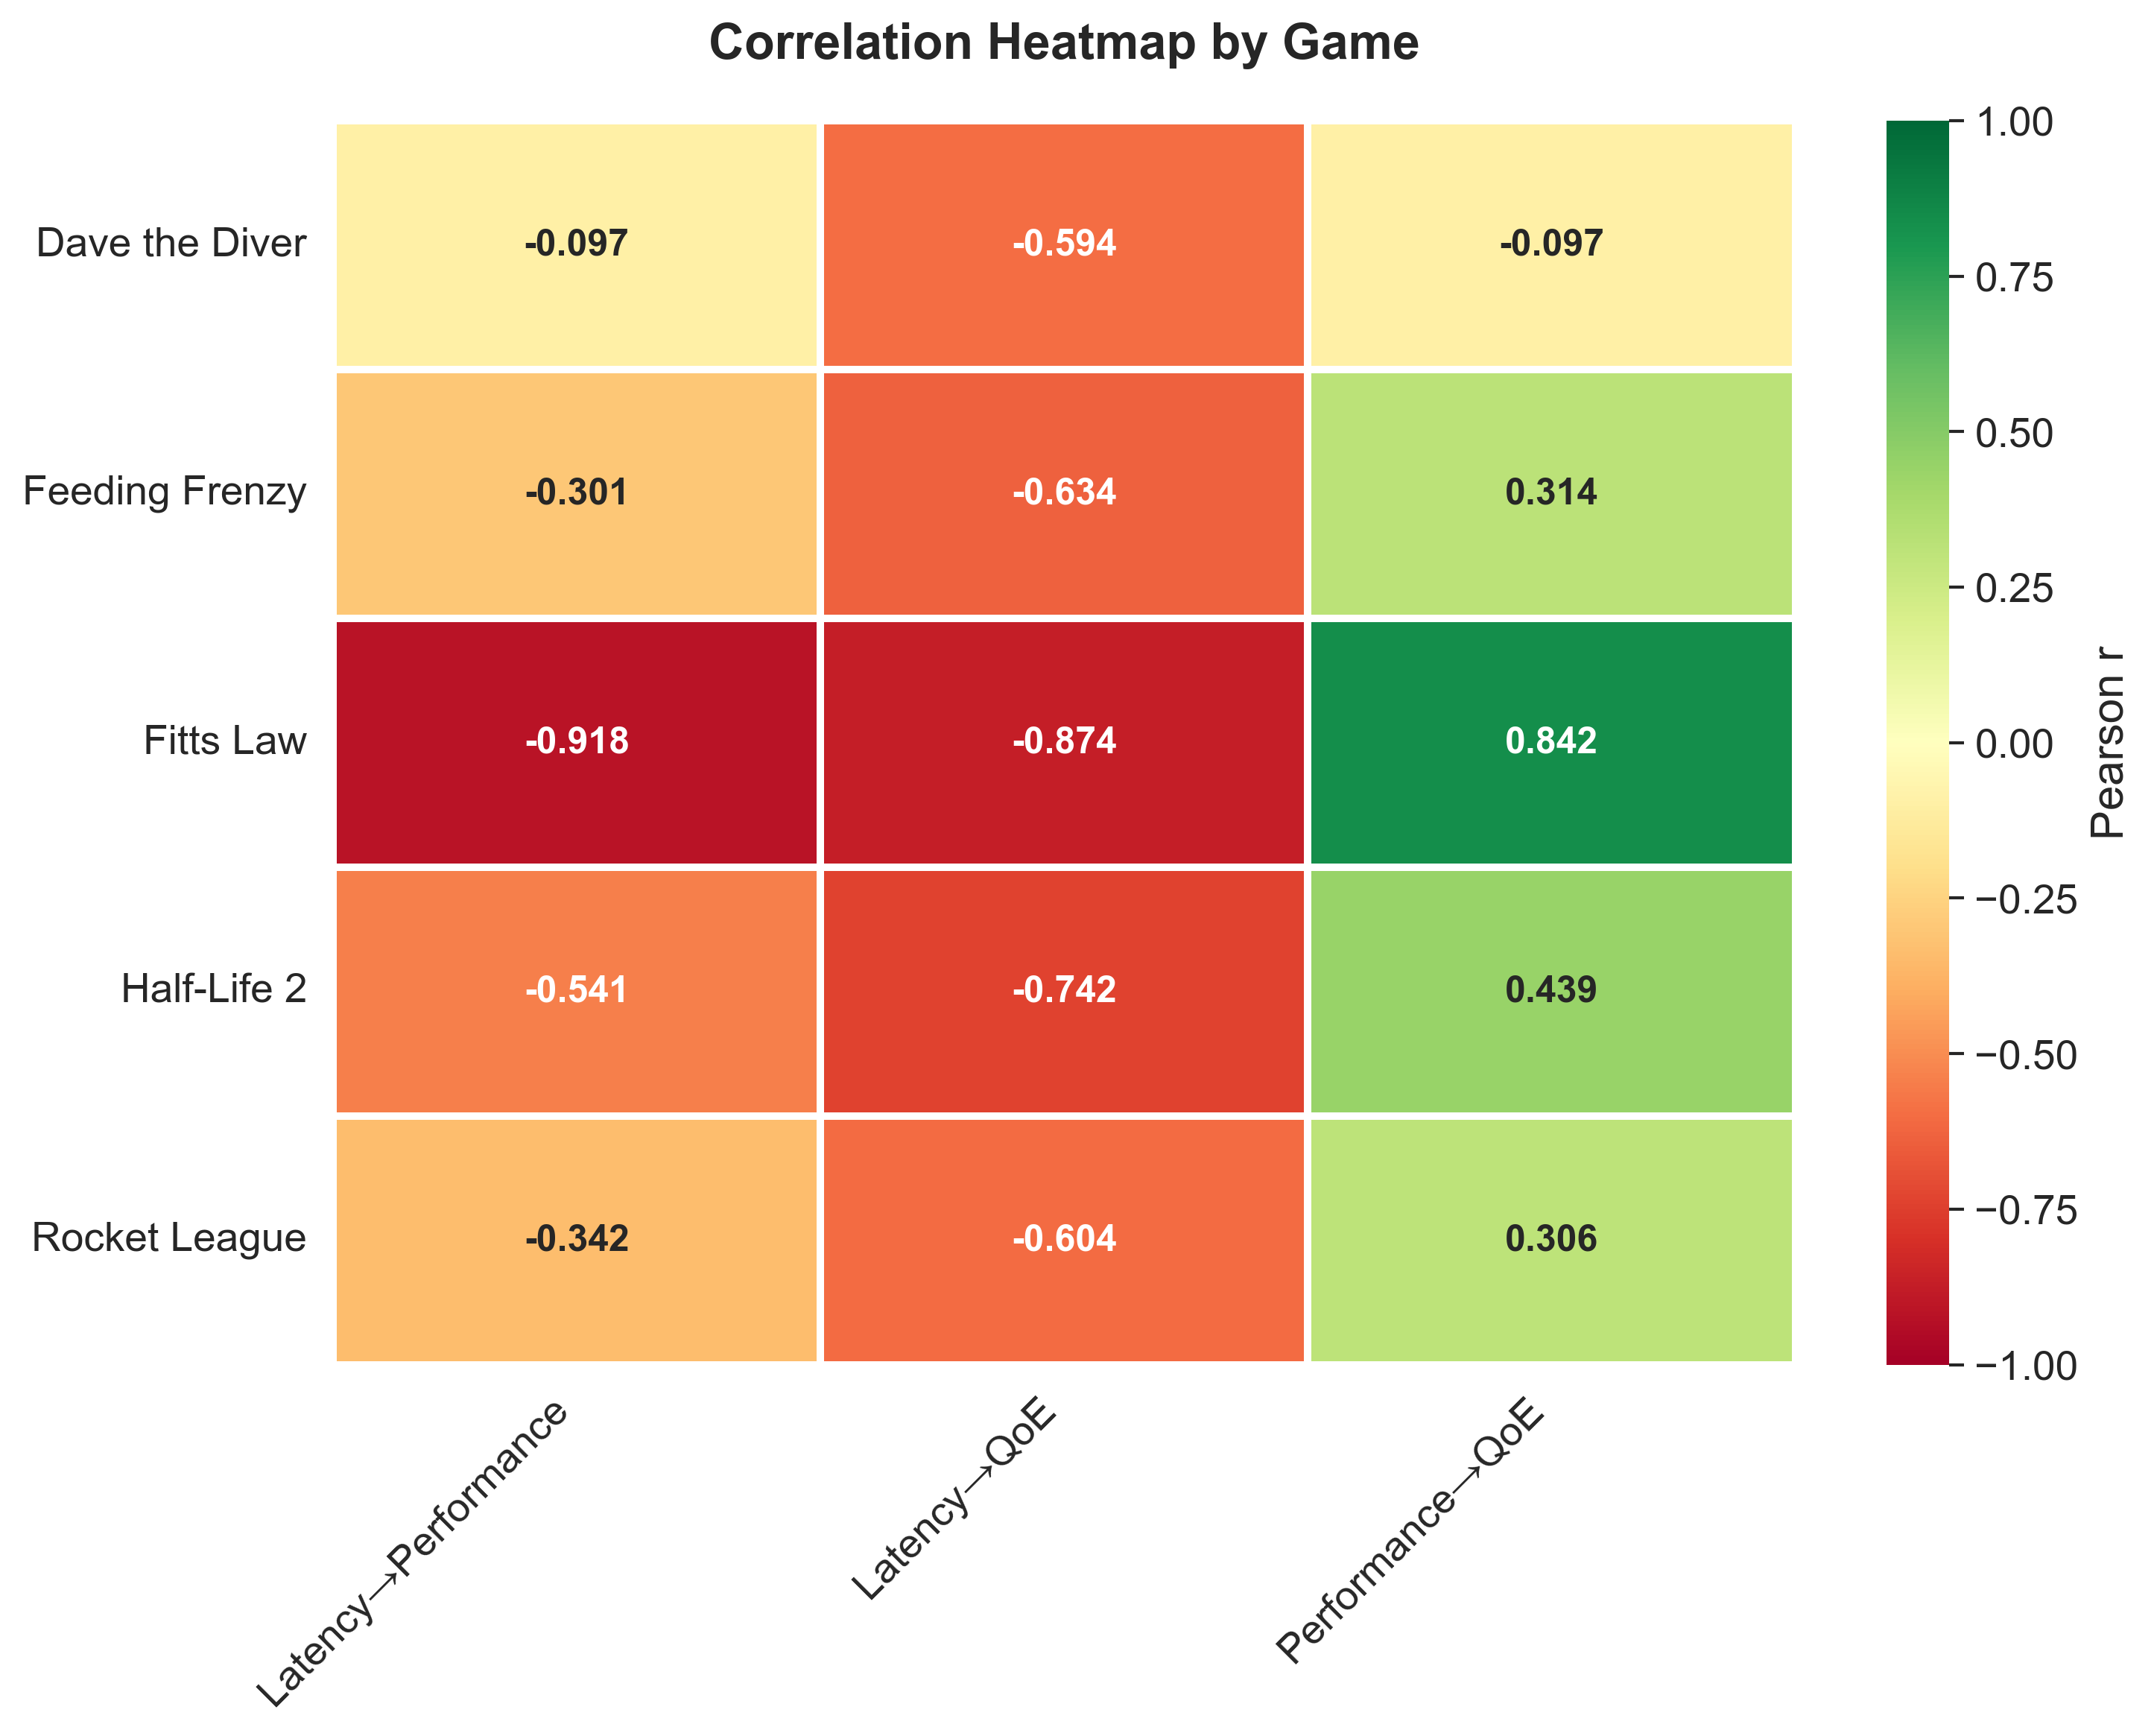

In [ ]:
# Calculate correlations for each game
correlation_matrix = []

for game in games:
    game_df = df[df['game_display'] == game].dropna(subset=['score', 'quality_rating'])
    if len(game_df) > 2:
        r_perf, _ = stats.pearsonr(game_df['latency_ms'], game_df['score'])
        r_qoe, _ = stats.pearsonr(game_df['latency_ms'], game_df['quality_rating'])
        r_perf_qoe, _ = stats.pearsonr(game_df['score'], game_df['quality_rating'])

        correlation_matrix.append({
            'Game': game,
            'Latency→Performance': r_perf,
            'Latency→QoE': r_qoe,
            'Performance→QoE': r_perf_qoe
        })

corr_df = pd.DataFrame(correlation_matrix).set_index('Game')

fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(corr_df, annot=True, cmap='RdYlGn', center=0, vmin=-1, vmax=1,
           linewidths=2, linecolor='white', cbar_kws={'label': 'Pearson r'},
           fmt='.3f', annot_kws={'size': 12, 'weight': 'bold'}, ax=ax)

ax.set_title('Correlation Heatmap by Game', fontsize=16, fontweight='bold', pad=20)
ax.set_xlabel('')
ax.set_ylabel('')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'correlation_heatmap.png', bbox_inches='tight')
plt.savefig(OUTPUT_DIR / 'correlation_heatmap.pdf', bbox_inches='tight')
print(f"Saved: {OUTPUT_DIR / 'correlation_heatmap.png'}")
plt.show()

## 7. Combined Performance & QoE Plot


Saved: ../analysis/figures/combined_performance_qoe.png


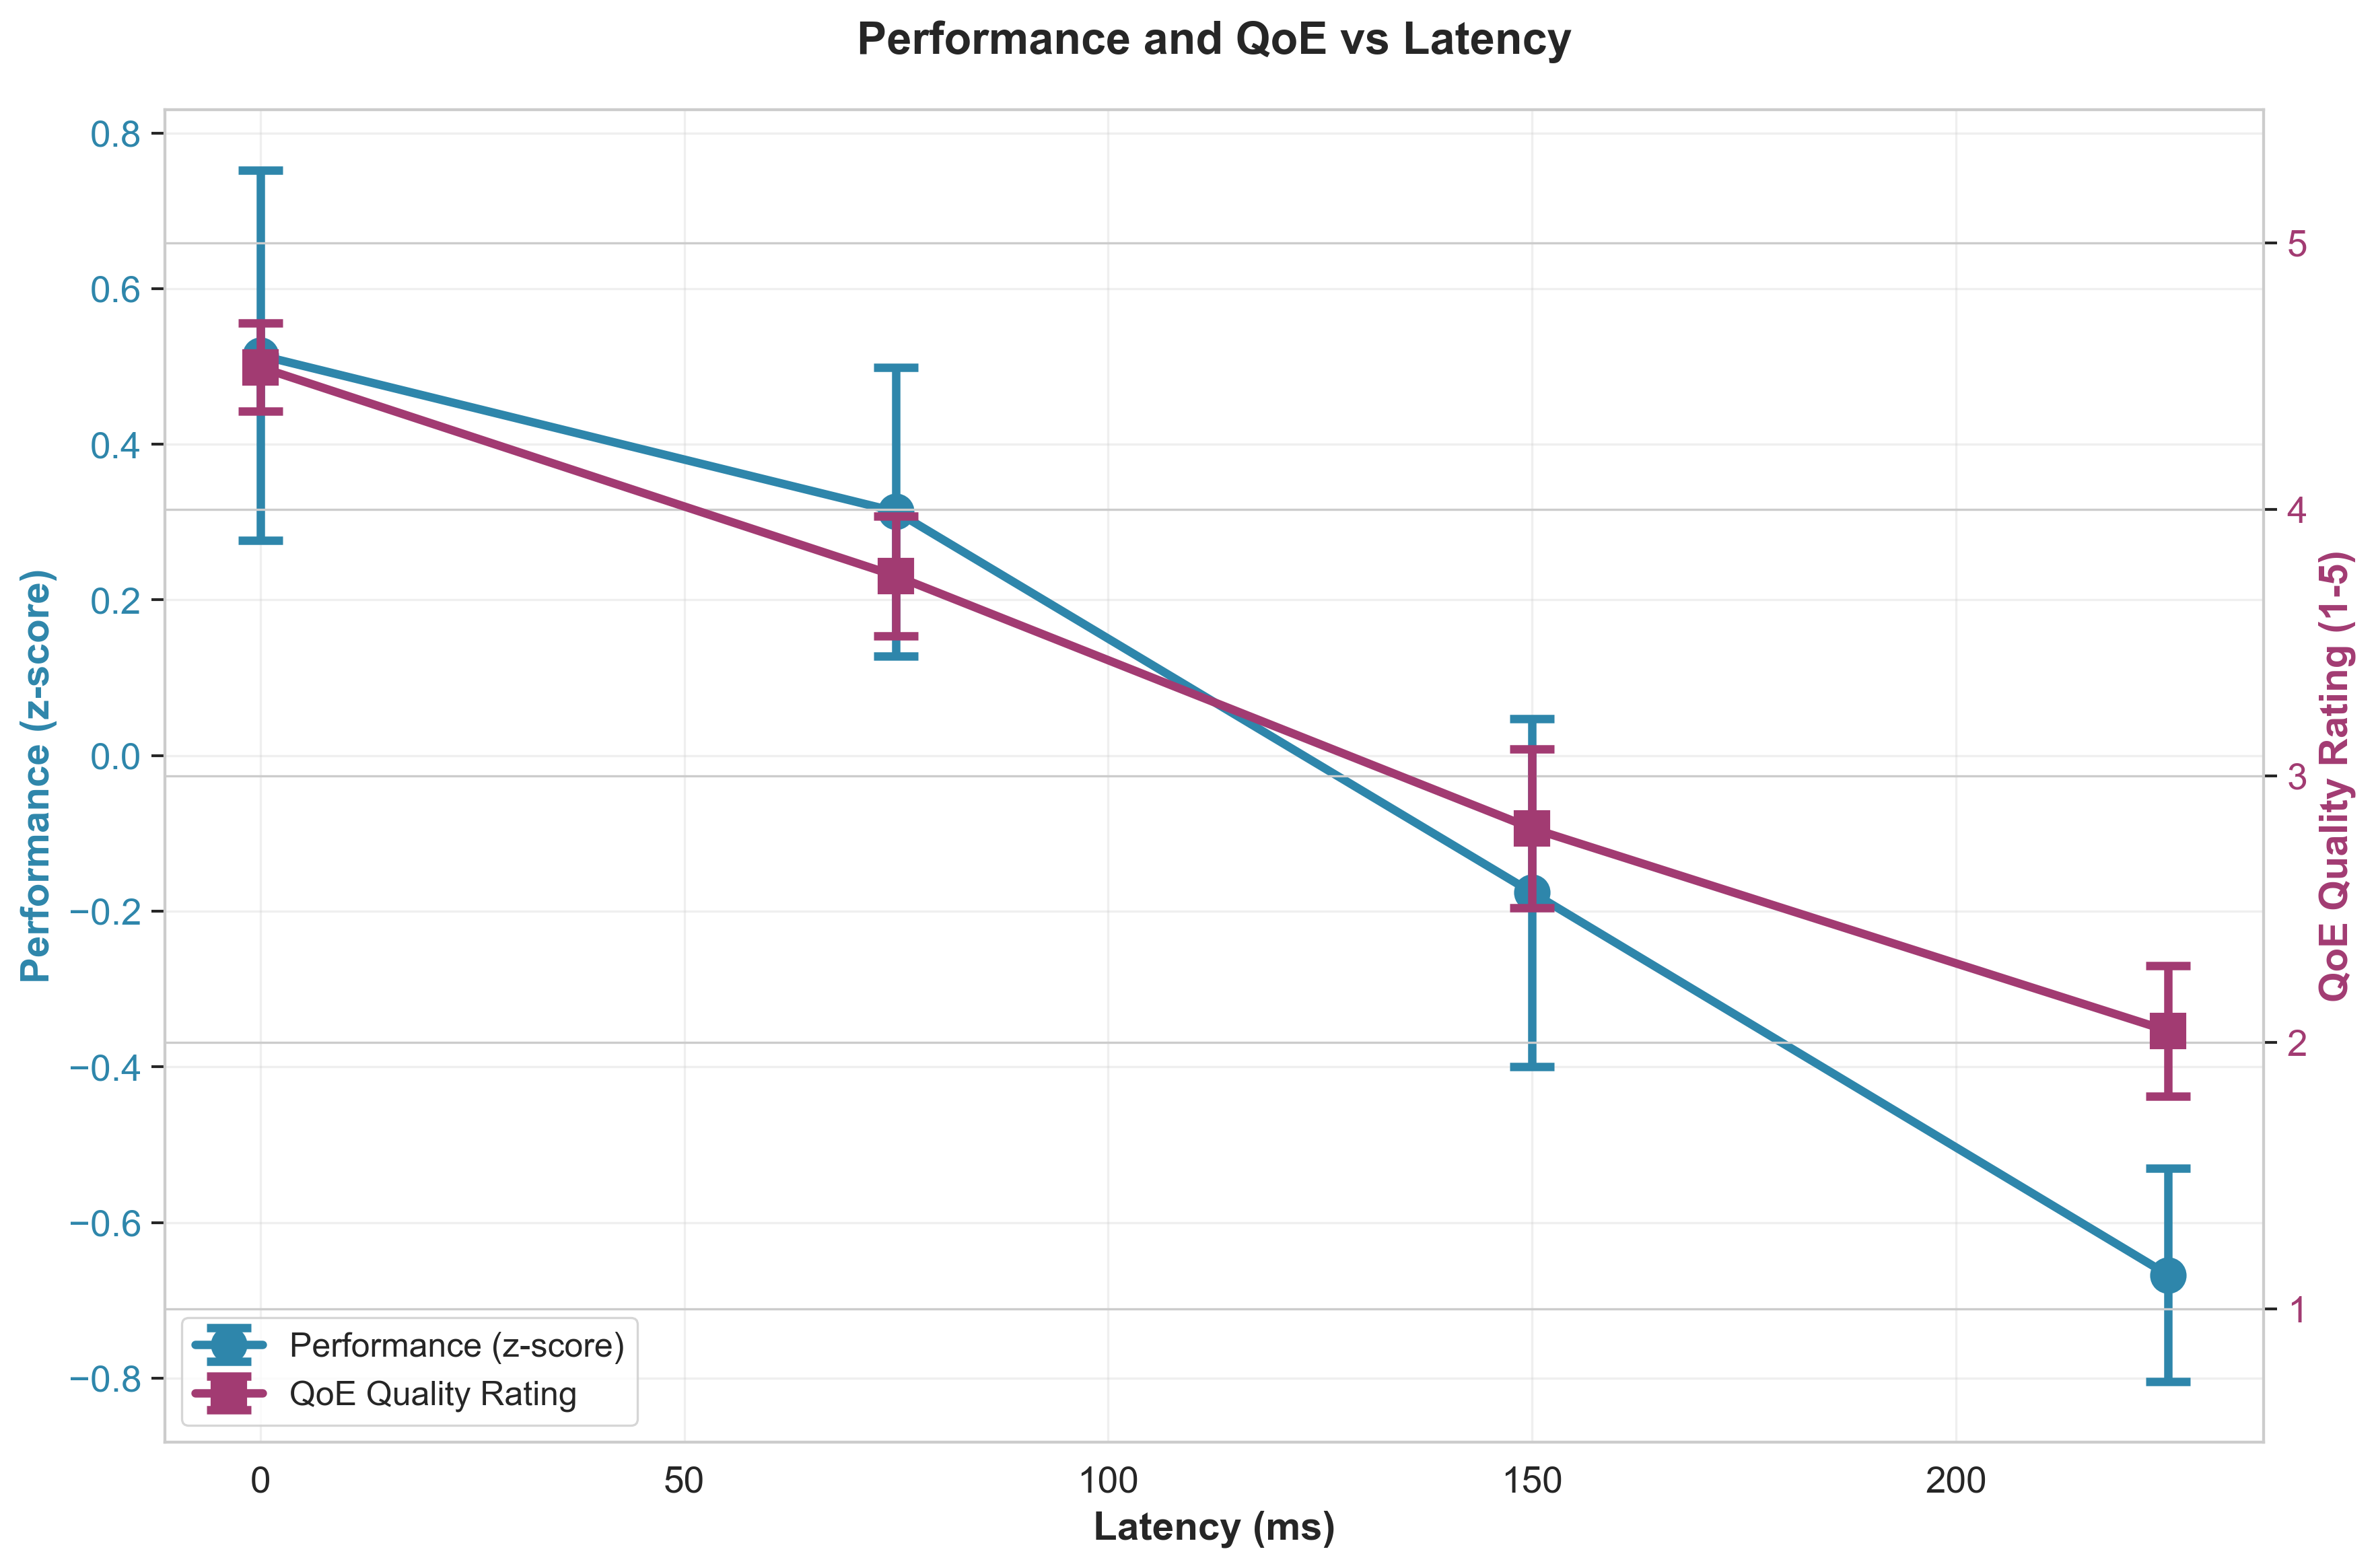

In [9]:
# Dual-axis plot showing both performance and QoE
fig, ax1 = plt.subplots(figsize=(12, 8))

# Calculate aggregated means
perf_summary = df.groupby('latency_ms')['score_z'].agg(['mean', 'sem']).reset_index()
perf_summary['ci'] = perf_summary['sem'] * 1.96

qoe_summary = df.dropna(subset=['quality_rating']).groupby('latency_ms')['quality_rating'].agg(['mean', 'sem']).reset_index()
qoe_summary['ci'] = qoe_summary['sem'] * 1.96

# Plot performance on left axis
color1 = '#2E86AB'
ax1.errorbar(perf_summary['latency_ms'], perf_summary['mean'], yerr=perf_summary['ci'],
            marker='o', markersize=12, linewidth=3, capsize=8, capthick=3,
            color=color1, label='Performance (z-score)')
ax1.set_xlabel('Latency (ms)', fontsize=14, fontweight='bold')
ax1.set_ylabel('Performance (z-score)', fontsize=14, fontweight='bold', color=color1)
ax1.tick_params(axis='y', labelcolor=color1)
ax1.grid(True, alpha=0.3)

# Plot QoE on right axis
ax2 = ax1.twinx()
color2 = '#A23B72'
ax2.errorbar(qoe_summary['latency_ms'], qoe_summary['mean'], yerr=qoe_summary['ci'],
            marker='s', markersize=12, linewidth=3, capsize=8, capthick=3,
            color=color2, label='QoE Quality Rating')
ax2.set_ylabel('QoE Quality Rating (1-5)', fontsize=14, fontweight='bold', color=color2)
ax2.tick_params(axis='y', labelcolor=color2)
ax2.set_ylim(0.5, 5.5)

# Title and legend
plt.title('Performance and QoE vs Latency', fontsize=16, fontweight='bold', pad=20)

# Combine legends
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='lower left', fontsize=12)

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'combined_performance_qoe.png', bbox_inches='tight')
plt.savefig(OUTPUT_DIR / 'combined_performance_qoe.pdf', bbox_inches='tight')
print(f"Saved: {OUTPUT_DIR / 'combined_performance_qoe.png'}")
plt.show()

## 8. QoE by Game and Latency


Saved: ../analysis/figures/qoe_by_game_latency.png


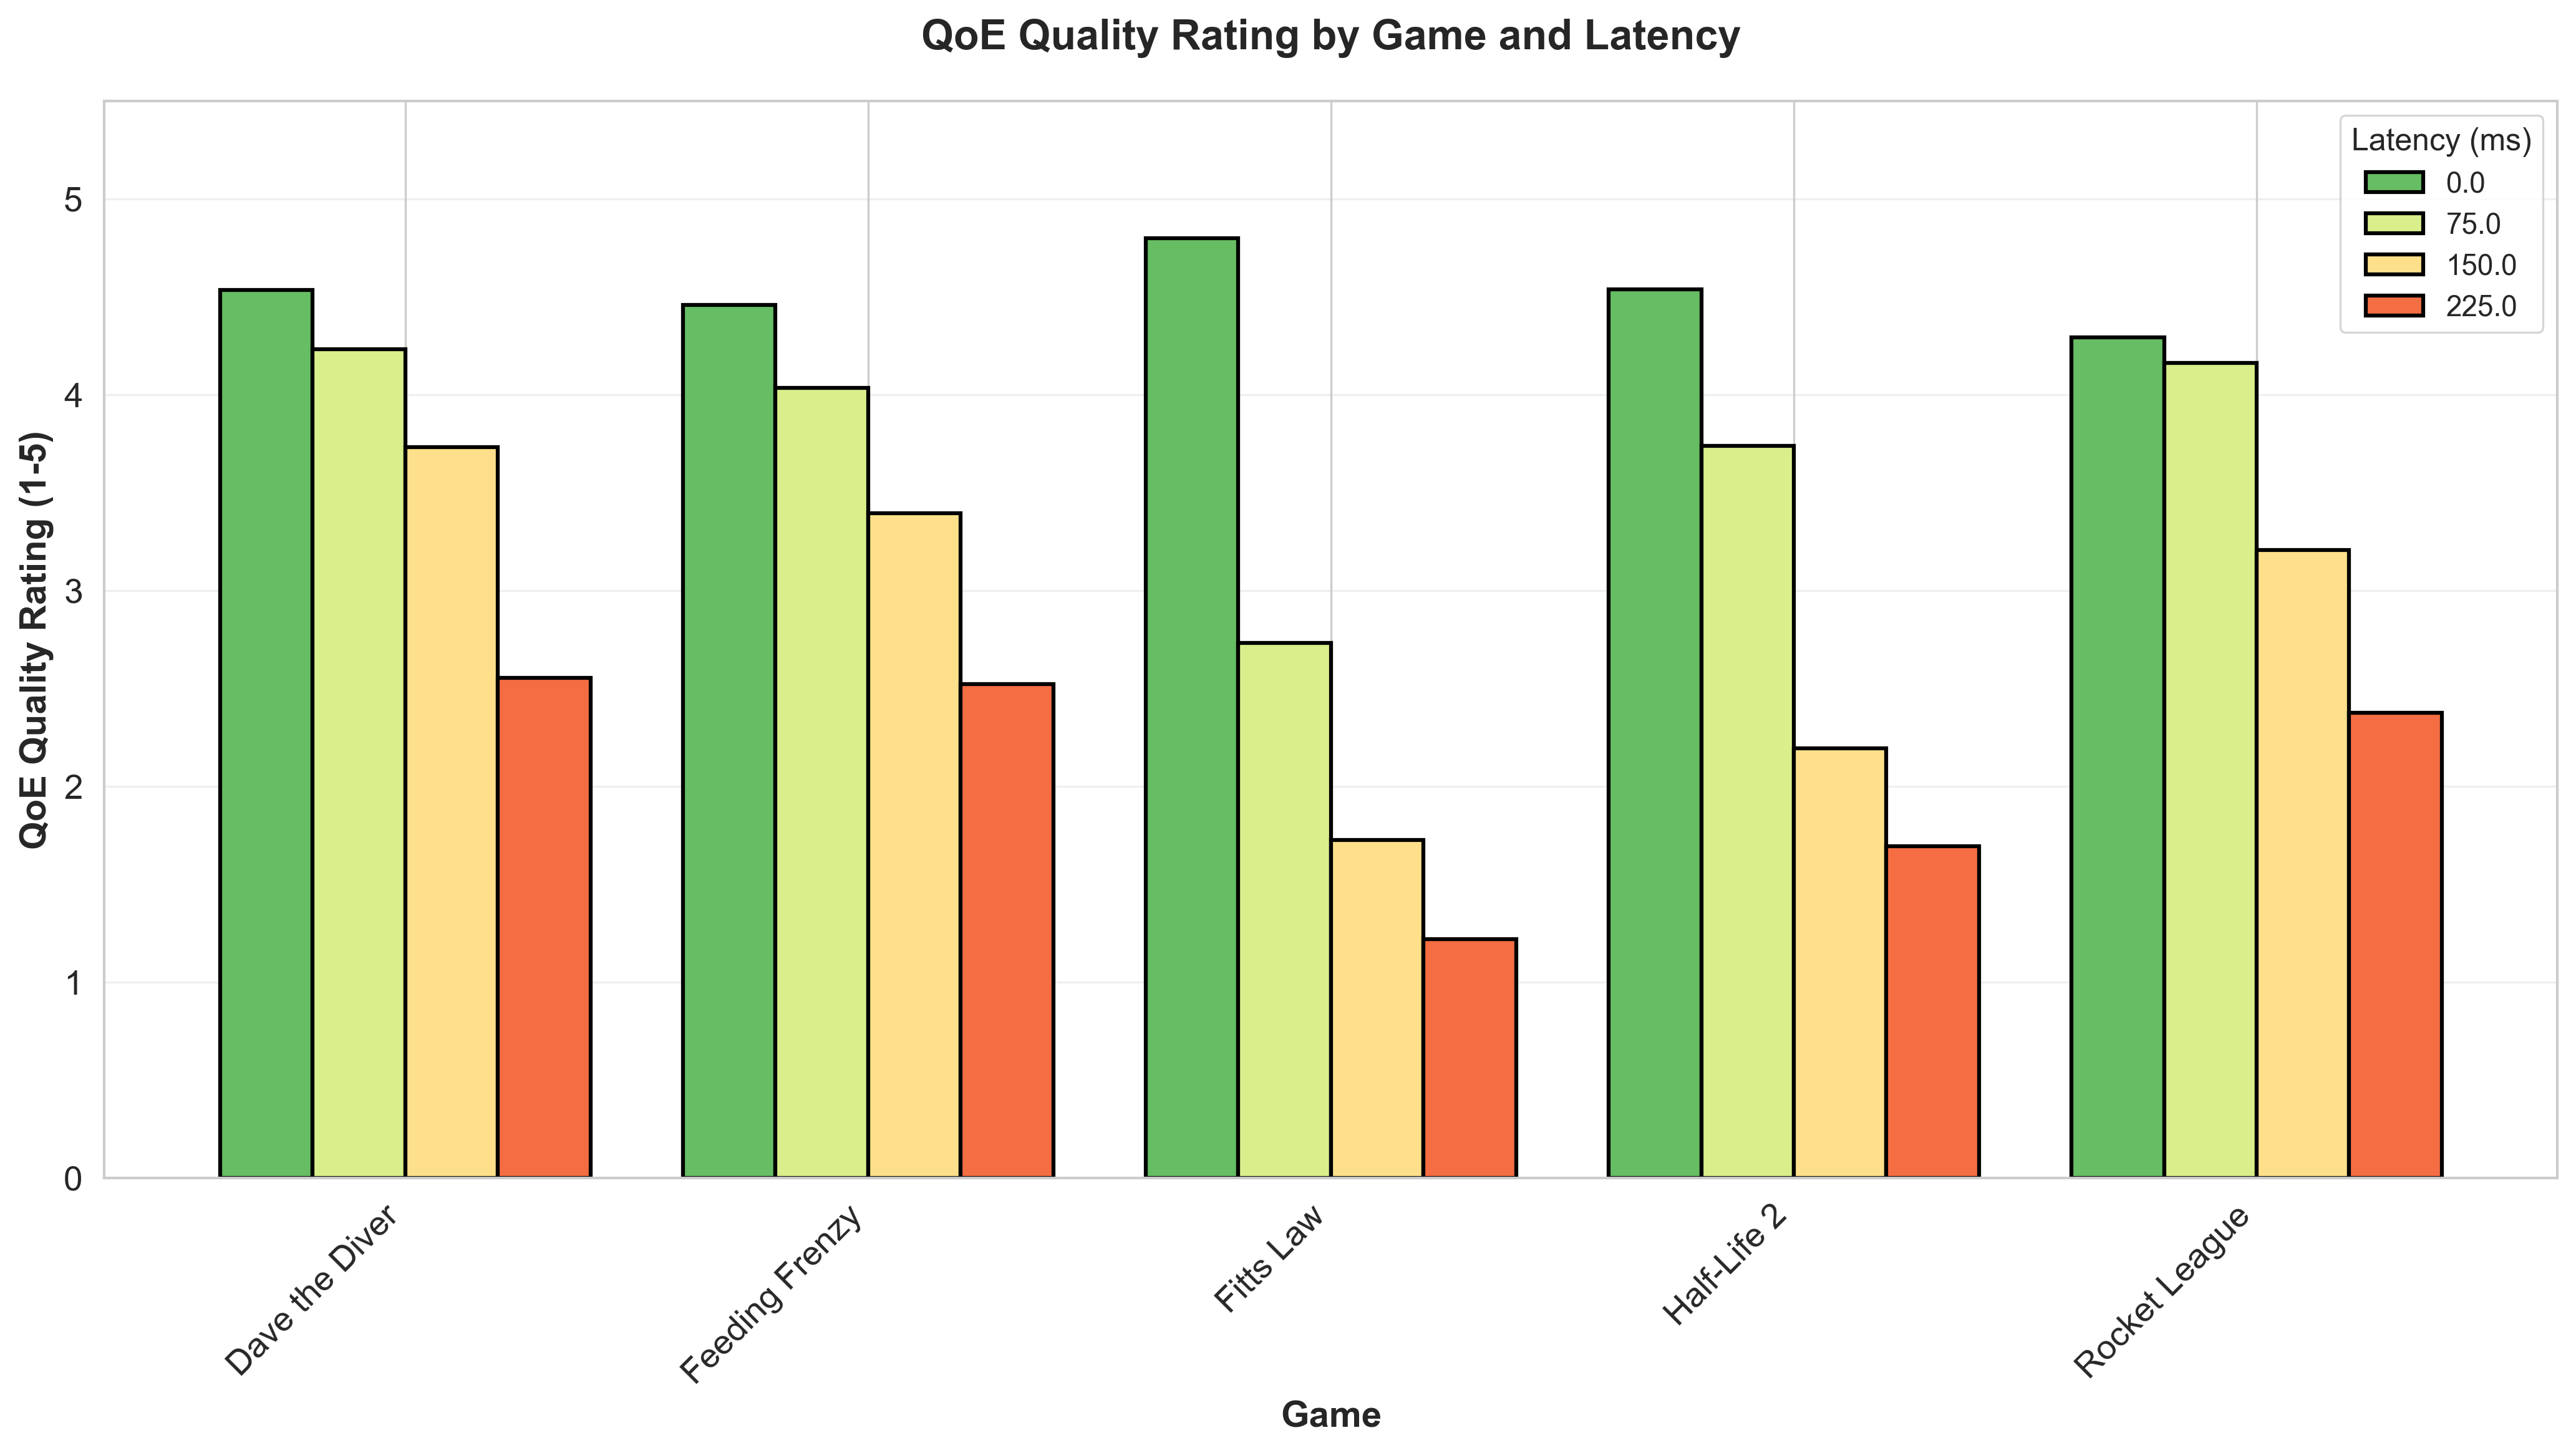

In [10]:
# Grouped bar chart showing QoE quality rating for each game at each latency
qoe_game_latency = df.dropna(subset=['quality_rating']).groupby(['game_display', 'latency_ms'])['quality_rating'].mean().unstack()

fig, ax = plt.subplots(figsize=(14, 8))
qoe_game_latency.plot(kind='bar', ax=ax, color=LATENCY_COLORS, width=0.8, edgecolor='black', linewidth=1.5)

ax.set_xlabel('Game', fontsize=14, fontweight='bold')
ax.set_ylabel('QoE Quality Rating (1-5)', fontsize=14, fontweight='bold')
ax.set_title('QoE Quality Rating by Game and Latency', fontsize=16, fontweight='bold', pad=20)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
ax.legend(title='Latency (ms)', fontsize=11, title_fontsize=12)
ax.set_ylim(0, 5.5)
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'qoe_by_game_latency.png', bbox_inches='tight')
plt.savefig(OUTPUT_DIR / 'qoe_by_game_latency.pdf', bbox_inches='tight')
print(f"Saved: {OUTPUT_DIR / 'qoe_by_game_latency.png'}")
plt.show()

## Summary

All visualizations created successfully!

**Generated figures:**

1. `performance_vs_latency_by_game.png` - Performance trends for each game
2. `qoe_vs_latency.png` - QoE quality and acceptability vs latency
3. `boxplots_by_latency.png` - Distribution of scores by latency
4. `individual_trajectories.png` - Per-participant performance patterns
5. `correlation_heatmap.png` - Correlation strengths by game
6. `combined_performance_qoe.png` - Dual-axis comparison
7. `qoe_by_game_latency.png` - QoE across games and conditions

All figures are saved in both PNG (for presentations) and PDF (for publications)
formats.
